In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive

/content/drive


In [ ]:
cd MyDrive/DoubleSac

/content/drive/MyDrive/DoubleSac


In [ ]:
cd MisLoc

/content/drive/MyDrive/DoubleSac/MisLoc


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
from scipy.stats import gamma as gammaFn
import pdb
from scipy.signal import find_peaks

class CANN1D: # One dimentional continuous attractor neural network model
    def __init__(self,args):

        self.totX = args.totX  # deg, retinal visual space range
        self.halfX = int(self.totX/2) # deg
        self.Nx = args.Nx # number of units covering totX
        self.dx = self.totX / self.Nx # deg/unit, spatial step size
        self.xs = np.arange(-self.halfX, self.halfX, self.dx) # deg, units' RF centers, fovea at 0 (center)
        self.x0 = args.x0 # deg, position of visual input relative to fixation (fovea) before saccade
        self.e0 = args.e0 # initial eye position (and initial fixation) relative to the screen center

        self.totT = args.totT # ms, total simulation time
        self.halfT = int(args.totT/2)
        self.dt = args.dt # ms, time step, 1
        self.tau = args.tau # ms, time constant
        self.Nt = int(self.totT/self.dt) # number of time steps

        self.sacDur = args.sacDur # ms, saccade duration, 50
        self.halfSacDur = args.sacDur//2

        self.respDelay = args.respDelay # ms, hard-shift part of retina to LIP input delay
        #  saccade onset; saccade duration covers the middle part of simulation T.
        self.sacOn = self.halfT-self.halfSacDur # ms
        self.sacOff = self.halfT+self.halfSacDur # ms

        self.ts = np.arange(0, self.totT, self.dt) # sampled times from 0
        self.tt = self.ts - self.sacOn # sampled times relative to saccade onset

        self.excSigma = args.excSigma # deg
        self.inhSigma = args.inhSigma
        self.excAmp = args.excAmp
        self.inhAmp = args.inhAmp
        self.inputSigma = args.inputSigma
        self.inputAmp = args.inputAmp # input amplitude
        self.sacAmp = args.sacAmp

        # symmetric connections
        self.Exc = self.excAmp*self._conn_sym(self.excSigma) # excitation part
        self.Inh = self.inhAmp*self._conn_sym(self.inhSigma) # inhibition part
        self.Jsym = self.Exc-self.Inh # net, Mexican-hat connections
        # anti-symmetric connections as 1st spatial derivative of symmetric connections
        self.dExc_dx = self.excAmp*self._conn_asy(self.excSigma)
        self.dInh_dx = self.inhAmp*self._conn_asy(self.inhSigma)
        self.Jasy = self.dExc_dx #- self.dInh_dx # also works if only use the 1st, exc part

        self.u = np.zeros(self.Nx)    # initialize states (membrane potentials)
        self.r = np.zeros(self.Nx)    # initialize activities (firing rates)
        self.input = np.zeros(self.Nx)    # initializw external visual input

        self.cdSigma = args.cdSigma
        self.cdAmp = args.cdAmp # maximum cd strength
        self.cdShift = args.cdShift
        self.cd = self._set_cd(self.cdAmp, self.cdSigma)

        # saccade suppression
        self.cdk = args.cdk # parameter for saccade supression
        self.suppress = self._set_sacsupress(self.cd, self.cdk)

        # use gamma pdf for temporal response
        self.gammaShape = args.gammaShape
        self.gammaScale = args.gammaScale
        self.gammaPeakT = (self.gammaShape - 1)*self.gammaScale # ms
        self.gammaFunc = gammaFn.pdf
        #self.gammaFunc = gammaFn.cdf

        # attention at the target which is sacAmp deg to the right of initial fixation
        self.attSigma = args.attSigma # deg, attention sigma
        self.attAmp = args.attAmp # attention amplitude
        # no attention at target in [noAtt1, noAtt2]. maybe use CD to gate attention ??
        self.noAttInd1 = int((self.sacOn - 100)/self.dt) # ms
        self.noAttInd2 = int((self.sacOff + 100)/self.dt) # ms

    def _conn_sym(self,sigma):
        """
        Symmetric connections as a 1d gaussian (unnormalized, with peak = 1)
        """
        Jxx = np.zeros((self.Nx, self.Nx))
        for i in range(self.Nx):
            for j in range(self.Nx):
                Jxx[i][j] = \
                np.exp(-0.5 * np.square((self.xs[i] - self.xs[j]) / sigma))
        return Jxx

    def _conn_asy(self,sigma):
        """
        Asymmetric connection as first-order derivative of a 1d gaussian function (unnormalized)
        """
        Jax = np.zeros((self.Nx, self.Nx))
        Jxx = self._conn_sym(sigma)
        for i in range(self.Nx):
            for j in range(self.Nx):
                Jax[i][j] = -Jxx[i][j]*(self.xs[j]-self.xs[i])/(sigma**2) # only true if Jsym is a gaussian
        return Jax

    def _set_cd(self, cdAmp, cdSigma):
        '''
        set cd signal as a 1d gaussian (unnormalized); time 0 should be mid saccade ??
        '''
        z = np.exp(-0.5*((self.ts - self.halfT-self.cdShift)/cdSigma)**2)
        self.cd_profile = z*cdAmp
        #pdb.set_trace()

        return z*cdAmp

    def _set_sacsupress(self, cd, cdk):
        #cd = self._set_cd()
        self.suppress = 1./(1+cdk*np.abs(cd)) #saccade suppression function: 1/(1+k*cd) # suppress=1 means no suppression
        return self.suppress



    def set_gaussianInput(self, Amp, x0):
        #_input_t = self._set_input_trace() # get center position of the gaussian bump
        #self.input = np.array([np.zeros_like(self.r)])
        gs = [self._gaussianBump(Amp, x0)] # the [] is need to for repeat to stack them
        self.input = np.repeat(gs, self.Nt, axis=0)


        return self.input

    def _gaussianBump(self, Amp, x0):
        '''
        gaussian centered at x0 with amplitude Amp
        '''
        gs = Amp * np.exp(-0.5 * np.square((self.xs - x0) / self.inputSigma));
        return gs

    def set_gammaInput(self, loc, shape, scale):
        """
        Gamma pdf function  does cdf case too
        """
        #t = np.linspace(0, self.totT, self.totT)
        #amp = gamma.pdf(t,shape,loc,scale)
        amp = self.gammaFunc(self.ts, shape, loc, scale) # loc is the added delay
        if np.max(amp) != 0:
            amp = amp/np.max(amp)
        else:
            print('set_gammaInput: max(amp) is 0')
        self.gamma =amp
        return self.gamma
    def set_persisInput(self,sacAmp):
        #amp = np.ones_like(self.ts)
        amp = np.array([np.zeros_like(self.r)])
        self.gamma = np.ones_like(self.ts)
        #amp=np.zeros_like(self.ts)
        #t0 = self.step_sacon+self.step_resp_delay+self.step_sac_dur//2
        t0 = self.halfT+self.respDelay
        tbins = self.ts - t0
        ts0  = sacAmp-sacAmp/(1+np.exp(0.12*tbins))+self.x0
        for pos in ts0:
            tmp_input = self._gaussianBump(self.inputAmp,pos)
            amp =np.append(amp,[tmp_input],axis=0)
        self.persis_input = amp
        return self.persis_input


    def setAtt(self, locus, Amp, sigma): # attention modulation factor
        att = 1 + Amp * np.exp(-0.5 * np.square((self.xs - locus) / sigma));
        return att

    def relu_r_or_u(self, u):
        # activation function
        r = 0.5 * (u + np.abs(u))
        return r

    def cann_step(self, i):

        #Run the network for one time step, i is the index of time step

        self.Jxx  = self.Jsym -self.cd[i]*self.Jasy #  time-varying cd signal modulate the asymmtric part   the products below
        self.u = self.u+(-self.u+np.dot(self.Jxx, self.r)+self.input[i]*self.gamma[i]*self.suppress[i])*self.dt/self.tau
        #self.u = self.u+(-self.u+np.dot(self.Jxx, self.r)+self.perssis_input[i]*self.suppress[i])*self.dt/self.tau
        #self.u = u_step # not needed
        self.r = self.relu_r_or_u(self.u)
        if self.attAmp != 0:
            if i < self.noAttInd1:
                self.r = self.r * self.att1
            elif i > self.noAttInd2:
                self.r = self.r * self.att2

    def cann_step2(self, i):
        '''
        Run the network for one time step, i is the index of time step
        '''
        self.Jxx  = self.Jsym -self.cd[i]*self.Jasy #  time-varying cd signal modulate the asymmtric part   the products below
        #self.u = self.u+(-self.u+np.dot(self.Jxx, self.r)+self.input[i]*self.gamma[i]*self.suppress[i])*self.dt/self.tau
        self.u = self.u+(-self.u+np.dot(self.Jxx, self.r)+self.persis_input[i]*self.suppress[i])*self.dt/self.tau
        #self.u = u_step # not needed
        self.r = self.relu_r_or_u(self.u)

    def pos_max(self):
        # find  max position of bump activity
        max_index = np.argmax(self.r)
        max_x = self.xs[max_index]
        return max_x

    def centerOfMass(self, x, r):
        x_r = r * x
        tmp = r.sum()
        if tmp != 0:
            center = x_r.sum()/tmp
        else:
            center = np.nan
            print('centerOfMass: denominator is 0.')
        return center



    def runCann(self, probeOn):
        # run model with a probe at probeOn (ms relative to the start of simulation)

        # inputs to recurrent LIP/FEF units
        self.set_gaussianInput(cann.inputAmp, cann.x1) # Set the visual input's spatial position
        self.set_gammaInput(probeOn+cann.respDelay, cann.gammaShape, cann.gammaScale) # set the time course of visual input
        # sptial attention profile
        if self.attAmp != 0:
            self.att1 = self.setAtt(sacAmp, self.attAmp, self.attSigma) # before saccade
            self.att2 = self.setAtt(0, self.attAmp, self.attSigma) # after saccade

        self.snapshots = np.zeros([cann.Nt, cann.Nx]) # initial a list to collect the outputs   Does not use the value of cann.u only its shape
        # run the model step by step and concate the output together at each step

        startTind = int((probeOn + cann.respDelay)/self.dt)
        for i in range(startTind, cann.Nt):
            self.cann_step(i)
            self.snapshots[i] = cann.r

        # determine the start and end Pos of center-of-mass of population activity
        #gammaPeakInd = np.argmax(cann.gamma) # peak time index for gamma input  # this is OK for transient input
        #self.gammaPeakInd = int((probeOn + self.respDelay + self.gammaPeakT)/cann.dt)
        #self.startPos = self.centerOfMass(self.xs, self.snapshots[self.gammaPeakInd])
        self.endPos = self.centerOfMass(self.xs, self.snapshots[-1])

    def runCann_persis(self, probeOn,sacAmp):
        self.set_persisInput(sacAmp)
        self.snapshots = np.zeros([cann.Nt, cann.Nx]) # initial a list to collect the outputs   Does not use the value of cann.u only its shape
        startTind = int((probeOn + cann.respDelay)/self.dt)
        for i in range(1, cann.Nt):
            self.cann_step2(i)
            self.snapshots[i] = cann.r
        self.endPos = self.centerOfMass(self.xs, self.snapshots[-1])



In [7]:
import easydict
# parameters of the model
args = easydict.EasyDict({
    "totX": 180, # deg, visual range (-90,90) deg
    "Nx": 360, # number of recurrent LIP units
    "totT" : 1000, # ms, total simulation time
    "dt": 1, # ms, time step
    "tau": 20, # ms, time constant
    "sacDur" : 50, # ms, saccade duration
    "excSigma" : 6, # deg, sigma of the excitation connections
    "inhSigma" : 9.6, # deg, sigma of the inhibition connections
    "excAmp" : 0.165, # amplitude of the excitation connections
    "inhAmp" : 0.1, # amplitude of the inhibition connections
    "inputSigma": 4, # deg, sigma of visual input
    "inputAmp" : 2, # amplitude of the visual input
    "x0" : 6, # deg, position of visual input relative to fixation (fovea) before saccade
    "e0" : -6, # initial eye position (and initial fixation) relative to the screen center
    "cdSigma": 60, # ms, sigma of cd signal
    "cdAmp" : 0.97, # max cd strength
    "respDelay":0, # ms, hard-shift part of retina to LIP delay
    "cdk" : 20, # paramter of saccade suppression
    "cdShift":0,
    "gammaShape": 6, # gamma distribution shape
    "gammaScale": 8, # ms, gamma distribution scale
    "attSigma": 8, # deg, attention sigma
    "attAmp": 0, # 0.1, attention amplitude
    "sacAmp":12
})



In [ ]:
cann.sacOn

315

In [8]:
# run model with a probe well before saccade onset to determine update amplitude
# and set saccade amplutude to the negative of this value. run this block once
# and then run the next block with any probe onset time.

cann = CANN1D(args) # create an instance of CANN1d
cann.attAmp = 0 # no attention

# probe onset on retina
probeOn = 0 # ms, retinal probe on the first time step
probeOnInd = int(probeOn/cann.dt)
cann.x1 = cann.x0 # x1 = x0 for flash before saccade

# probe should be early enough not to miss CD time course
if cann.sacOn - probeOn < cann.cdSigma*3:
    print('probe onset not early enough')

cann.runCann(probeOn)

# set saccade amplitude to the negative of total updating so that the flash
# well before saccade is updated correctly after the saccade. This also means that
# persistent stimuli will be updated correctly, the definition of TSVS.
endPos = cann.centerOfMass(cann.xs, cann.snapshots[-1])
sacAmp = cann.x0 - cann.endPos
print(sacAmp)

midTind = int(cann.Nt/2) # mid index of sampled time array
idealUpdate = sacAmp/(1+np.exp(0.12*(cann.tt - cann.tt[midTind]))) + endPos
eyeTrace = sacAmp/(1+np.exp(-0.12*(cann.tt - cann.tt[midTind]))) + cann.e0
#cann.sacAmp = -sacAmp

11.964501083351635


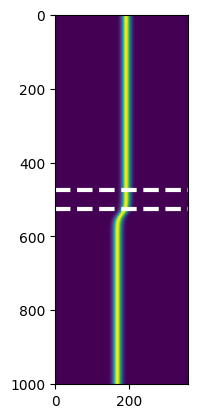

In [9]:
#Plot the input
cann.respDelay = 40
input_all = cann.set_persisInput(-sacAmp)
import matplotlib.pyplot as plt
plt.imshow(input_all)
plt.plot([0,args.Nx-1],[cann.sacOn,cann.sacOn],linestyle = '--',color = 'w',linewidth = 3)
plt.plot([0,args.Nx-1],[cann.sacOff,cann.sacOff],linestyle = '--',color = 'w',linewidth = 3)


In [10]:
# run the model at any probeOn time
probeIni = 0
args.respDelay = 40
cann = CANN1D(args) # create an instance of CANN1d
# probe onset on retina
probeOn = probeIni# ms cann.sacOn cann.sacOff probeIni = 20
probeOnInd = int(probeOn/cann.dt)
eyeChange = eyeTrace[probeOnInd] - eyeTrace[0]
# for flashes on a fixed screen position, its retinotopic position changes with eye position
cann.x1 = cann.x0 - eyeChange

cann.runCann_persis(probeOn,-sacAmp)

In [ ]:
cann.cd[470]

0.8560219955070576

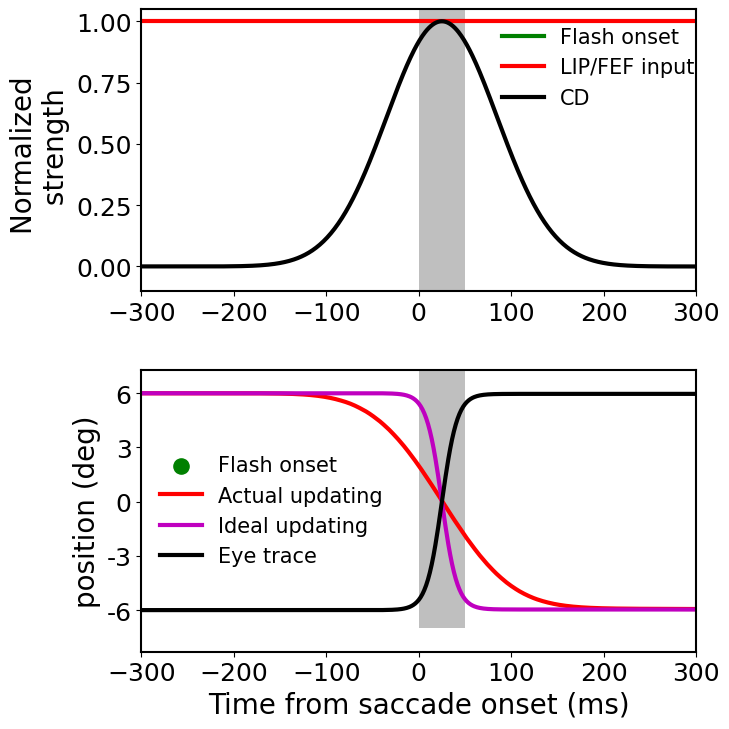

In [11]:
from matplotlib import colormaps
import matplotlib
#plt.rcParams['figure.figsize'] = (7, 4)
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.labelsize']= 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['lines.linewidth'] = 3

figSzS = (7, 4)
figSzB = (8, 8)
lgndSz = 15
fontsize = 20

plt.figure(figsize=figSzB)

ax = plt.subplot(211)
# flash time
ax.plot([probeOn-cann.sacOn,probeOn-cann.sacOn],[0,1],'g',label='Flash onset')
# time course of the LIP/FEF input (gamma function)
gInput = np.ones_like(cann.ts)
ax.plot(cann.tt, gInput, 'r', label='LIP/FEF input')
# cd time course
cd = cann.cd/np.max(cann.cd) # normalize
ax.plot(cann.tt, cd,'k',label='CD')
#plt.legend(loc='upper right')
if probeOn == probeIni:

 lgnd = ax.legend(loc=(0.635,0.62), prop={'size': lgndSz},fontsize =15)
 lgnd.get_frame().set_linewidth(0.0)
 lgnd.get_frame().set_facecolor('none')
#plt.legend(loc=(0.65,0.62))
ax.fill_between([0,cann.sacDur], -0.1, 1.1, facecolor='grey', alpha = 0.5)
plt.ylabel('Normalized \n strength',fontsize = fontsize)
#plt.xlim([-cann.halfT, cann.halfT])
plt.xlim([-300, 300])
plt.ylim([-0.1, 1.05])



ax = plt.subplot(212)

# time index for having cortical (LIP/FEF) responses
ctxOnInd = int((probeOn+cann.respDelay)/cann.dt) # add cann.dt for the response to appear

#ax.scatter(cann.tt[probeOnInd], cann.x1, s=120,color='r',label='Flash onset',marker='o',zorder=11)
ax.scatter(cann.tt[probeOnInd], cann.x1, s=120, color='g', label='Flash onset', marker='o',zorder=10)# input marker

com_list = [] # center of mass
max_fr = []
for i in range(ctxOnInd, cann.Nt):
    #peaks, _ = find_peaks(snapshots[i,:], height=0) # get the peak position of the bump.
    center = cann.centerOfMass(cann.xs, cann.snapshots[i,:])
    #peak_list.append(cann.xs[peaks[0]])
    com_list.append(center)
    max_fr.append(cann.snapshots[i,:].max())
norm_fr = np.array(max_fr)/np.array(max_fr).max()
#norm_alpha = norm_fr
plt_t = cann.tt[ctxOnInd:cann.Nt]
plt_y = com_list

ax.plot(cann.tt[ctxOnInd:cann.Nt], com_list, 'r', label='Actual updating') # actual updating

plt.plot(cann.tt[ctxOnInd:cann.Nt], idealUpdate[ctxOnInd:cann.Nt], label='Ideal updating',color='m') # ideal updating
plt.plot(cann.tt, eyeTrace, label='Eye trace',color='k')
if probeOn == probeIni:#
 lgnd = ax.legend(loc=0, prop={'size': lgndSz})
 lgnd.get_frame().set_linewidth(0.0)
 lgnd.get_frame().set_facecolor('none')
plt.yticks([-6,-3,0,3,6],['-6','-3','0','3','6'])
plt.xlabel('Time from saccade onset (ms)',fontsize = fontsize)
plt.ylabel('position (deg)',fontsize = fontsize)
ax.fill_between([0,cann.sacDur], -7, 10, facecolor='grey', alpha = 0.5)
if probeOn == cann.sacOn:
  plt.arrow(220,-sacAmp/2,0,6,head_width=10,head_length=1,color='k')
if probeOn == cann.sacOff:
  plt.arrow(220,-sacAmp/2,0,-0.52,head_width=7,head_length=0.5,color='k')
#plt.xlim([-cann.halfT, cann.halfT])
plt.xlim([-300,300])
plt.ylim([-8.3,7.3])
plt.tight_layout()  # Adjusts layout to prevent overlap

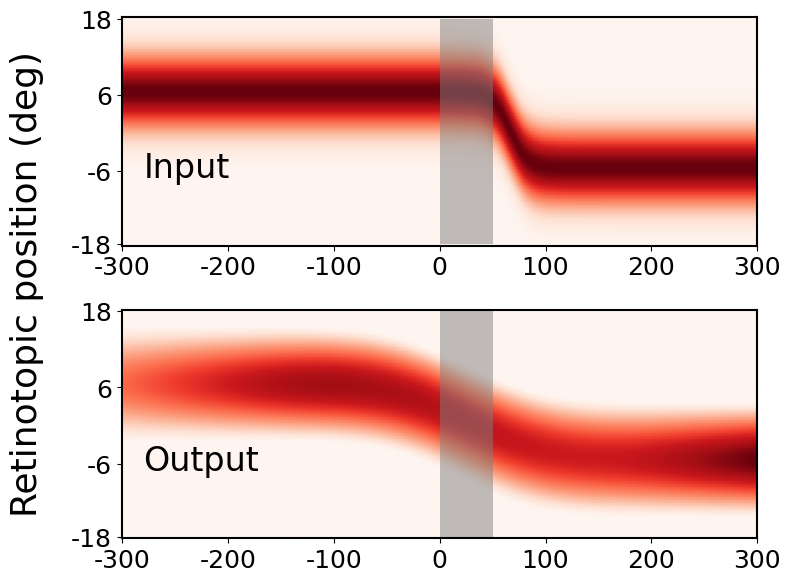

In [12]:
# plot the results for one probeOn time
from matplotlib import colormaps
import matplotlib
#plt.rcParams['figure.figsize'] = (7, 4)
matplotlib.rcParams['font.size'] = 30
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.labelsize']= 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['lines.linewidth'] = 3

lgndSz = 15
plotIndY = [175,175+600] # plotIndY = [160,840]
plotInd=[180-36,180+36]

sacOn = cann.sacOn-plotIndY[0]
sacOff = cann.sacOff-plotIndY[0]
Nx = plotInd[1]-plotInd[0]
fig=plt.figure(figsize=(8,8),dpi = 100)
aspect = 3
ax = plt.subplot(211)

#cann.input.shape
gauss_input = cann.input

gamma = cann.gamma[:,np.newaxis]
tem_input = np.repeat(gamma, args.Nx, axis=1)
input_all = cann.persis_input
#input_all.shape
cmap = plt.cm.Reds
max_value = input_all.max()
min_value = input_all.min()
input_all = input_all.T
input_all = np.flipud(input_all)
plt.imshow(input_all[plotInd[0]:plotInd[1],plotIndY[0]:plotIndY[1]],cmap=cmap, vmin=min_value, vmax=max_value)
ax.fill_between([sacOn,sacOff],0,Nx-1,facecolor='grey', alpha = 0.5)
ax.set_aspect(aspect)
ax.text(20,50,'Input',fontsize=24)

plt.yticks([0,24,48,71],['18','6','-6','-18'])
plt.xticks([sacOn-300,sacOn-200,sacOn-100,sacOn,sacOn+100,sacOn+200,sacOn+300],['-300','-200','-100','0','100','200','300'])

plt.tight_layout()  # Adjusts layout to prevent overlap

fig.text(-0.02,0.21,'Retinotopic position (deg)',fontsize = 26,rotation=90)



#fig=plt.figure(figsize=(8,6),dpi = 100)

ax = plt.subplot(212)


cmap = plt.cm.Reds
max_value = cann.snapshots[plotIndY[0]:plotIndY[1],plotInd[0]:plotInd[1]].max()
min_value = cann.snapshots[plotIndY[0]:plotIndY[1],plotInd[0]:plotInd[1]].min()
snapshots = cann.snapshots[plotIndY[0]:plotIndY[1],plotInd[0]:plotInd[1]].T
snapshots = np.flipud(snapshots)
plt.imshow(snapshots,cmap=cmap, vmin=min_value, vmax=max_value)
ax.set_aspect(aspect)
ax.fill_between([sacOn,sacOff],0,Nx-1,facecolor='grey', alpha = 0.5)
#remap_x = 26.5*2+180
#plt.plot([remap_x,remap_x],[560,590],color='w',linewidth=3)
#plt.xticks([0,90,180,270,360],['-90','-45','0','45','90'])
plt.yticks([0,24,48,71],['18','6','-6','-18'])
plt.xticks([sacOn-300,sacOn-200,sacOn-100,sacOn,sacOn+100,sacOn+200,sacOn+300],['-300','-200','-100','0','100','200','300'])

ax.text(20,50,'Output',fontsize=24)

#plt.xlabel('Time from saccade onset (ms)',fontsize = fontsize)
#plt.yticks([sacOn-300,sacOn-200,sacOn-100,sacOn,sacOn+100,sacOn+200,sacOn+300],['-300','-200','-100','0','100','200','300'])
#plt.xlabel('Position (deg)')
plt.subplots_adjust( hspace=-0.3)



In [ ]:
cann.sacOn

315

In [ ]:
cann.x1

6.0

In [ ]:
args.cdShift

20

In [ ]:
# run the mislocalization curve
# a list of flash times for the mislocalization curve
cann.respDelay=20
probeOnList = np.array([0, cann.totT-cann.respDelay-2*cann.dt]) # 2dt for responses to appear
probeOnList = np.insert(probeOnList, 1, np.arange(cann.halfT-180,cann.halfT+120,10)) # insert a list of times
probeOnList = np.arange(0,cann.totT-30,5) # time points of the curve
max_x = [] # initiaize a list to collect the center-of-mass position of population activity
flash_pos = []
args.cdShift = 0
args.respDelay=20
for _probeOnset in probeOnList: # run the model for each time points
      cann = CANN1D(args)


      probeOnInd = int(_probeOnset/cann.dt)
      eyeChange = (eyeTrace[probeOnInd] - eyeTrace[0])
      cann.x1 = cann.x0 - eyeChange # flash retinal position
      flash_pos.append(cann.x1)

      cann.runCann(_probeOnset)

      max_x_ = cann.centerOfMass(cann.xs, cann.r)
      #max_x_ = cann.intp_pos_max() # interpolation
      max_x.append(max_x_)



In [ ]:
probeOnList

array([  0, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270,
       280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400,
       410, 420, 430, 440, 450, 678])